In [1]:
import csv
from collections import defaultdict
from collections import namedtuple
from functools import partial
from itertools import product
from pathlib import Path
from typing import TypedDict

import torch
import seaborn as sns
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torchvision import models as tv_models
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [2]:
BATCH_SIZE = 100
LR = 0.001
OUT_FILEPATH = Path("./results.csv")
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

# Output file settings
ERASE_RESULTS = True
FIELDS = ["model_desc", "accuracy",]


class Row(TypedDict):
    model_desc: str
    accuracy: float


torch.manual_seed(42);

In [3]:
def one_hot(class_: int) -> torch.Tensor:
    vec = torch.zeros(10, dtype=torch.float32)
    vec[class_] = 1.0

    return vec

In [4]:
dataset_factory = partial(CIFAR10, root="./data", download=True, target_transform=one_hot)
train_dataset_factory = partial(dataset_factory, train=True)
test_dataset_factory = partial(dataset_factory, train=False)
dataloader_factory = partial(DataLoader, batch_size=BATCH_SIZE)

In [5]:
# Create/erase output file for results
if ERASE_RESULTS:
    with open(OUT_FILEPATH, 'w', newline='') as out:
        csv_writer = csv.DictWriter(out, FIELDS)

        # Write data from previous practice
        csv_writer.writerow(Row(
            model_desc='ResNet18\n Special for CIFAR10',
            accuracy=0.91,
        ))

    del out

In [6]:
def classifier(in_features, deep=False, num_classes=10):
    if not deep:
        return nn.Linear(in_features, num_classes)

    hidden_size = 100

    return nn.Sequential(
        nn.Linear(in_features, hidden_size),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_size, num_classes),
    )

In [7]:
def get_correct(predictions, ground_truth) -> int:
    with torch.no_grad():
        correct = (
            (predictions.argmax(dim=1) == ground_truth.argmax(dim=1))
            .cpu()
            .detach()
            .to(torch.int32)
            .sum()
            .item()
        )

    return correct

In [8]:
def train_model(model, dataloader, criterion, optimizer, num_epochs) -> float:
    model = model.to(DEVICE)
    model.train()
    accuracy = 0

    for epoch_no in range(1, num_epochs + 1):
        running_loss = 0
        train_mean_loss = 0
        correct = 0
        total = 0

        for signals, ground_truth in tqdm(
            dataloader,
            desc='Train batches',
            total=len(dataloader),
        ):
            optimizer.zero_grad()

            signals = signals.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(signals)
            loss_value = criterion(predictions, ground_truth)
            loss_value.backward()

            optimizer.step()

            correct += get_correct(predictions, ground_truth)
            total += len(predictions)
            mean_loss = torch.mean(loss_value.cpu().detach()).item()
            running_loss += mean_loss

            train_mean_loss = running_loss / len(dataloader)

        accuracy = correct / total

        print(
            f'Epoch: {epoch_no:02d} '
            f'| train loss: {train_mean_loss:.4f} '
            f'| accuracy: {accuracy:.4f}\n'
        )

    return accuracy


def test_model(model, dataloader) -> float:
    model = model.to(DEVICE)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, ground_truth in tqdm(
            dataloader,
            desc='Test batches',
            total=len(dataloader),
        ):
            data = data.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(data)
            correct += get_correct(predictions, ground_truth)
            total += len(predictions)

    return correct / total

In [9]:
Pretrained = namedtuple('Pretrained', ['model', 'weights', 'name', 'out_features'])

# Each model has either 'fc' nor 'classifier' linear layer attribute
pretrained = [
    Pretrained(tv_models.mobilenet_v3_small, tv_models.MobileNet_V3_Small_Weights.DEFAULT, 'MobileNetV3 S', 576),
    Pretrained(tv_models.mnasnet0_75, tv_models.MNASNet0_75_Weights.DEFAULT, 'MNASNet 0.5', 1280),
    Pretrained(tv_models.resnet18, tv_models.ResNet18_Weights.DEFAULT, 'ResNet18', 512),
    Pretrained(tv_models.efficientnet_v2_s, tv_models.EfficientNet_V2_S_Weights.DEFAULT, 'EfficientNetV2 S', 1280),
]

In [10]:
Config = namedtuple('Config', ['deep', 'num_epochs'])

configs = [
    Config(deep=True, num_epochs=9),
    Config(deep=False, num_epochs=5),
]

In [11]:
best_model = ""
best_accuracy = 0

for (pretrained_model, weights, model_name, out_features), config in product(pretrained, configs):
    transform = weights.transforms()

    train_dataloader = dataloader_factory(train_dataset_factory(transform=transform))
    test_dataloader = dataloader_factory(test_dataset_factory(transform=transform))

    model = pretrained_model(weights=weights)

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add new classifier
    classifier_placeholder = classifier(out_features, deep=config.deep)

    if hasattr(model, 'fc'):
        model.fc = classifier_placeholder
    elif hasattr(model, 'classifier'):
        model.classifier = classifier_placeholder
    else:
        raise RuntimeError("Model does not have known out layers")

    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(
        (getattr(model, 'fc', None) or getattr(model, 'classifier')).parameters(),
        LR,
    )

    print(model)

    __ = train_model(model, train_dataloader, criterion, optimizer, config.num_epochs)
    test_accuracy = test_model(model, test_dataloader)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = (
            str(model)
            + f'\nClassifier: {"deep" if config.deep else "simple"}'
            + f'\nNum epochs: {config.num_epochs}'
            + f'\nTest accuracy: {test_accuracy}'
        )

    print(f'Test accuracy: {test_accuracy:.4f}')

    with open(OUT_FILEPATH, 'a', newline='') as out:
        csv_writer = csv.DictWriter(out, FIELDS)
        addon = '\nDeep classifier' if config.deep else ''

        csv_writer.writerow(Row(
            model_desc=model_name + addon + f'\n{config.num_epochs} epochs',
            accuracy=test_accuracy,
        ))

del best_accuracy

Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (

Train batches: 100%|██████████| 500/500 [01:15<00:00,  6.61it/s]


Epoch: 01 | train loss: 0.8626 | accuracy: 0.7134



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch: 02 | train loss: 0.6048 | accuracy: 0.7906



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 03 | train loss: 0.5509 | accuracy: 0.8098



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 04 | train loss: 0.5210 | accuracy: 0.8184



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 05 | train loss: 0.4949 | accuracy: 0.8283



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


Epoch: 06 | train loss: 0.4760 | accuracy: 0.8349



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Epoch: 07 | train loss: 0.4604 | accuracy: 0.8399



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.97it/s]


Epoch: 08 | train loss: 0.4440 | accuracy: 0.8456



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 09 | train loss: 0.4319 | accuracy: 0.8492



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Test accuracy: 0.8434
Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid

Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 01 | train loss: 0.9495 | accuracy: 0.7175



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Epoch: 02 | train loss: 0.6312 | accuracy: 0.7901



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 03 | train loss: 0.5736 | accuracy: 0.8049



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 04 | train loss: 0.5429 | accuracy: 0.8151



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


Epoch: 05 | train loss: 0.5226 | accuracy: 0.8212



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Test accuracy: 0.8186
Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/mnasnet0_75-7090bc5f.pth" to C:\Users\Ruslan/.cache\torch\hub\checkpoints\mnasnet0_75-7090bc5f.pth
100%|██████████| 12.3M/12.3M [00:01<00:00, 7.03MB/s]


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch: 01 | train loss: 0.9193 | accuracy: 0.6905



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 02 | train loss: 0.6885 | accuracy: 0.7629



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 03 | train loss: 0.6334 | accuracy: 0.7805



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch: 04 | train loss: 0.5914 | accuracy: 0.7953



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 05 | train loss: 0.5630 | accuracy: 0.8041



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 06 | train loss: 0.5331 | accuracy: 0.8144



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 07 | train loss: 0.5081 | accuracy: 0.8233



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch: 08 | train loss: 0.4818 | accuracy: 0.8316



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 09 | train loss: 0.4593 | accuracy: 0.8388



Test batches: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Test accuracy: 0.6357
Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, a

Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Epoch: 01 | train loss: 0.9785 | accuracy: 0.6991



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 02 | train loss: 0.7042 | accuracy: 0.7629



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 03 | train loss: 0.6500 | accuracy: 0.7783



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 04 | train loss: 0.6191 | accuracy: 0.7884



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch: 05 | train loss: 0.5979 | accuracy: 0.7962



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Test accuracy: 0.6466
Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch: 01 | train loss: 0.9271 | accuracy: 0.6831



Train batches: 100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Epoch: 02 | train loss: 0.7219 | accuracy: 0.7502



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch: 03 | train loss: 0.6816 | accuracy: 0.7602



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch: 04 | train loss: 0.6595 | accuracy: 0.7692



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch: 05 | train loss: 0.6405 | accuracy: 0.7754



Train batches: 100%|██████████| 500/500 [01:13<00:00,  6.77it/s]


Epoch: 06 | train loss: 0.6229 | accuracy: 0.7806



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.70it/s]


Epoch: 07 | train loss: 0.6107 | accuracy: 0.7852



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Epoch: 08 | train loss: 0.5961 | accuracy: 0.7918



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch: 09 | train loss: 0.5883 | accuracy: 0.7922



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Test accuracy: 0.7755
Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


Epoch: 01 | train loss: 0.9553 | accuracy: 0.6922



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch: 02 | train loss: 0.6973 | accuracy: 0.7625



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Epoch: 03 | train loss: 0.6597 | accuracy: 0.7729



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch: 04 | train loss: 0.6410 | accuracy: 0.7785



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch: 05 | train loss: 0.6291 | accuracy: 0.7815



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Test accuracy: 0.7711
Files already downloaded and verified
Files already downloaded and verified
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Train batches: 100%|██████████| 500/500 [05:21<00:00,  1.56it/s]


Epoch: 01 | train loss: 1.1033 | accuracy: 0.6304



Train batches: 100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Epoch: 02 | train loss: 0.8916 | accuracy: 0.6919



Train batches: 100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Epoch: 03 | train loss: 0.8483 | accuracy: 0.7064



Train batches: 100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


Epoch: 04 | train loss: 0.8247 | accuracy: 0.7131



Train batches: 100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


Epoch: 05 | train loss: 0.8027 | accuracy: 0.7179



Train batches: 100%|██████████| 500/500 [05:25<00:00,  1.53it/s]


Epoch: 06 | train loss: 0.7861 | accuracy: 0.7234



Train batches: 100%|██████████| 500/500 [05:26<00:00,  1.53it/s]


Epoch: 07 | train loss: 0.7706 | accuracy: 0.7283



Train batches: 100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


Epoch: 08 | train loss: 0.7588 | accuracy: 0.7341



Train batches: 100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Epoch: 09 | train loss: 0.7477 | accuracy: 0.7357



Test batches: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


Test accuracy: 0.7608
Files already downloaded and verified
Files already downloaded and verified
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Train batches: 100%|██████████| 500/500 [05:26<00:00,  1.53it/s]


Epoch: 01 | train loss: 1.1620 | accuracy: 0.6324



Train batches: 100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


Epoch: 02 | train loss: 0.9078 | accuracy: 0.6908



Train batches: 100%|██████████| 500/500 [05:26<00:00,  1.53it/s]


Epoch: 03 | train loss: 0.8654 | accuracy: 0.7052



Train batches: 100%|██████████| 500/500 [05:26<00:00,  1.53it/s]


Epoch: 04 | train loss: 0.8396 | accuracy: 0.7091



Train batches: 100%|██████████| 500/500 [05:25<00:00,  1.53it/s]


Epoch: 05 | train loss: 0.8212 | accuracy: 0.7186



Test batches: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s]

Test accuracy: 0.7424


In [12]:
print(best_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [13]:
data = defaultdict(list)

with open(OUT_FILEPATH, 'r') as in_:
    csv_reader = csv.DictReader(in_, FIELDS)

    for row in csv_reader:
        for key, value in row.items():
            if key == 'accuracy':
                value = float(value)

            data[key].append(value)

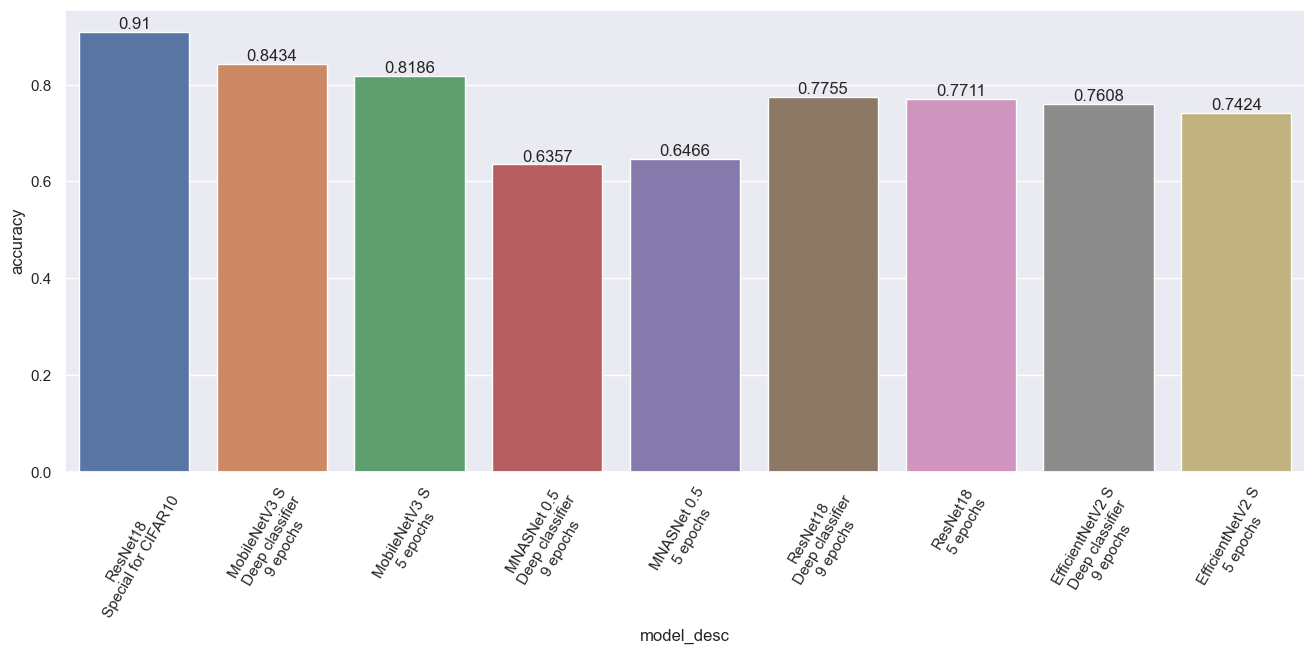

In [14]:
sns.set(rc={'figure.figsize': (16, 6)})

g = sns.barplot(data=data, x='model_desc', y='accuracy', hue="model_desc")
for item in g.get_xticklabels():
    item.set_rotation(60)

for i in g.containers:
    g.bar_label(i)  # type: ignore